# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

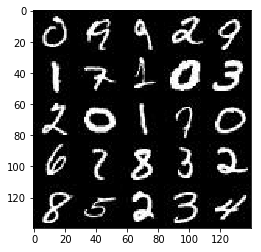

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

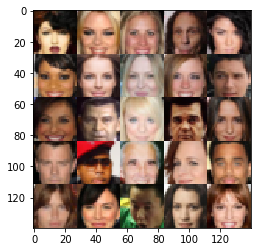

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    learn_rate = tf.placeholder(dtype=tf.float32, shape=(None))
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    
    alpha = 0.9    
    is_training = True # for the discriminator, batch_normalization is always set on training mode
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # input: 28 * 28 * num_channels    
        x = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, strides=2, activation=None, padding='same')
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)

        # input: 14 * 14 * 32    
        x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, activation=None, padding='same')
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(tensor=x, shape=(-1, 7*7*64))
        x = tf.layers.dense(inputs=x, units=1, activation=None)
        logits = tf.sigmoid(x)
        
        return x, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, reuse=False, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.9

    with tf.variable_scope("generator", reuse=reuse):
        
        # connect random input z to a dense layer
        x = tf.layers.dense(inputs=z, units=7*7*64, activation=None)

        # apply batch normalization and leaky relu activation
        x = tf.reshape(x, shape=(-1, 7, 7, 64))
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # input: 7*7*64 
        x = tf.layers.conv2d_transpose(inputs=x, filters=32, activation=None, kernel_size=5, strides=2, padding='same')
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # output: 14 *14*32
        
        # input: 14*14*32 
        x = tf.layers.conv2d_transpose(inputs=x, filters=out_channel_dim, activation=None, kernel_size=5, strides=2, padding='same')
        # output: 28*28*out_channel_dim
        
        # rescale output using tanh
        g_model = tf.tanh(x)
        
        return g_model


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(z = input_z, out_channel_dim=out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    all_vars = [v for v in tf.trainable_variables() ]
    g_vars = [v for v in all_vars if v.name.startswith('generator')]
    d_vars = [v for v in all_vars if v.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """


    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, beta1=beta1, learning_rate=learning_rate)
    
    show_fig_every_batch = 100
    show_loss_every_batch = 50
    
    num_channels = data_shape[3]
    if(num_channels == 1):
        image_mode = 'L'
    else:
        image_mode = 'RGB'
        
    show_images = 16
    random_constant_z = tf.random_uniform(dtype=tf.float32, minval=-1, maxval=1, shape=(show_images,z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):

            batch_num = 0
            for batch_images in get_batches(batch_size):
                
                batch_num +=1
                sample_z = np.random.uniform(high=1, low=-1, size=[batch_size, z_dim])                
                
                _ , discr_loss = sess.run([d_opt, d_loss], feed_dict={input_real: batch_images, input_z: sample_z})
                
                _ , gener_loss = sess.run([g_opt, g_loss], feed_dict={input_real: batch_images, input_z: sample_z}) 

                if(batch_num%show_loss_every_batch == 0 ):
                    print("discriminator loss: ", discr_loss, "generator loss: ", gener_loss)
                
                if(batch_num%show_fig_every_batch == 0):
                    show_generator_output(sess=sess, n_images=show_images, input_z=random_constant_z, out_channel_dim=num_channels, image_mode=image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

In [ ]:
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

discriminator loss:  1.51801 generator loss:  0.368139
discriminator loss:  1.23473 generator loss:  0.54842


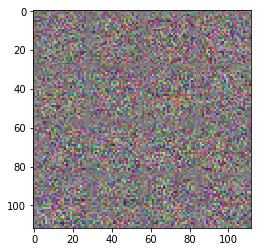

discriminator loss:  1.10173 generator loss:  0.628274
discriminator loss:  1.04046 generator loss:  0.670665


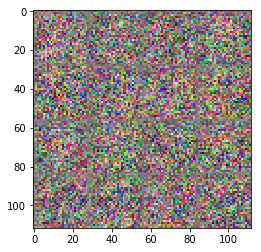

discriminator loss:  1.0223 generator loss:  0.681634
discriminator loss:  1.02387 generator loss:  0.678738


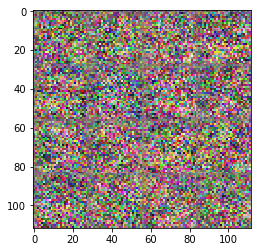

discriminator loss:  1.01051 generator loss:  0.690481
discriminator loss:  1.01145 generator loss:  0.688594


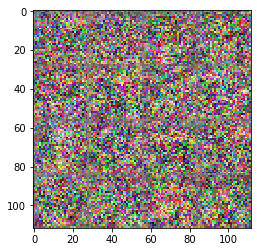

discriminator loss:  1.00913 generator loss:  0.691272
discriminator loss:  1.01087 generator loss:  0.689712


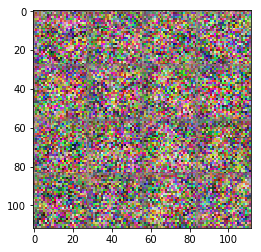

discriminator loss:  1.01152 generator loss:  0.691706
discriminator loss:  1.01022 generator loss:  0.691396


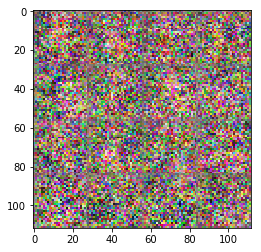

discriminator loss:  1.00772 generator loss:  0.691919
discriminator loss:  1.00873 generator loss:  0.691824


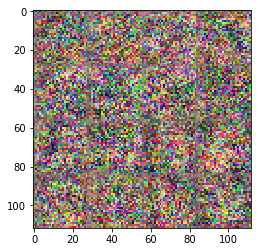

discriminator loss:  1.0077 generator loss:  0.691965
discriminator loss:  1.00724 generator loss:  0.69259


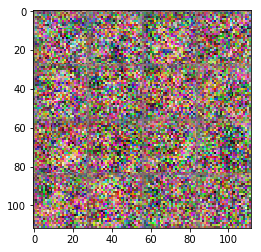

discriminator loss:  1.00813 generator loss:  0.692123
discriminator loss:  1.00777 generator loss:  0.692097


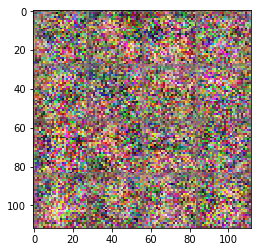

discriminator loss:  1.00741 generator loss:  0.692608
discriminator loss:  1.00691 generator loss:  0.692695


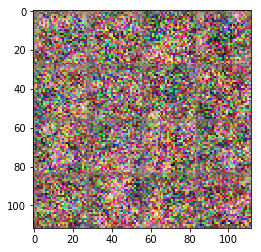

discriminator loss:  1.00712 generator loss:  0.692589
discriminator loss:  1.00691 generator loss:  0.692679


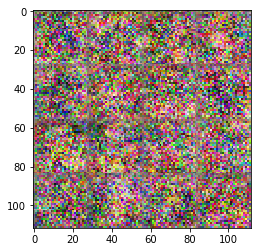

discriminator loss:  1.00694 generator loss:  0.692668
discriminator loss:  1.00693 generator loss:  0.692714


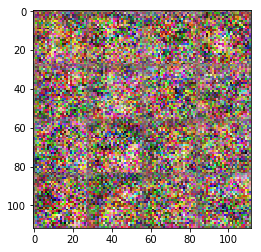

discriminator loss:  1.00679 generator loss:  0.692864
discriminator loss:  1.00708 generator loss:  0.692569


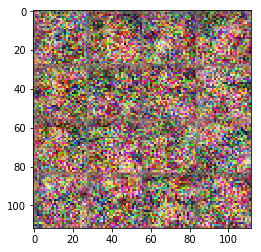

discriminator loss:  1.00671 generator loss:  0.692868
discriminator loss:  1.0067 generator loss:  0.692886


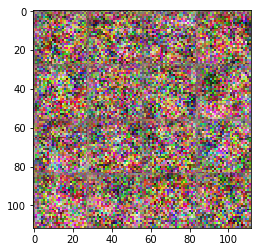

discriminator loss:  1.00711 generator loss:  0.692909
discriminator loss:  1.00668 generator loss:  0.692986


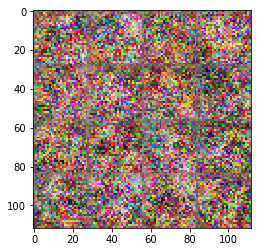

discriminator loss:  1.00663 generator loss:  0.692931
discriminator loss:  1.00681 generator loss:  0.692975


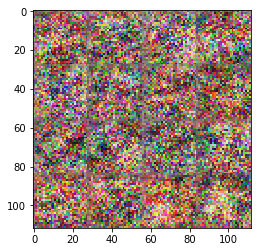

discriminator loss:  1.00695 generator loss:  0.692943
discriminator loss:  1.00672 generator loss:  0.692879


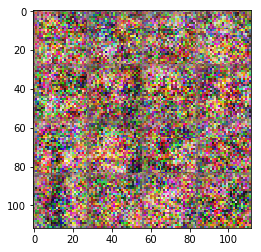

discriminator loss:  1.00663 generator loss:  0.692952
discriminator loss:  1.00672 generator loss:  0.692848


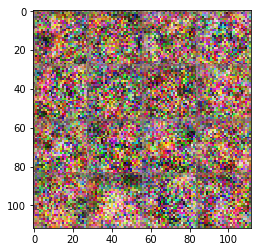

discriminator loss:  1.00656 generator loss:  0.69303
discriminator loss:  1.00661 generator loss:  0.692954


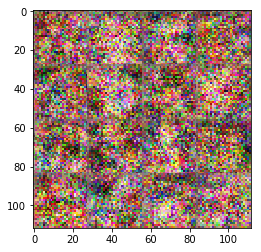

discriminator loss:  1.00665 generator loss:  0.692921
discriminator loss:  1.00659 generator loss:  0.693004


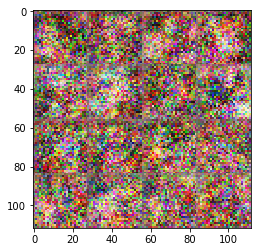

discriminator loss:  1.00663 generator loss:  0.693
discriminator loss:  1.00662 generator loss:  0.692959


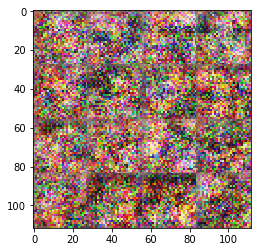

discriminator loss:  1.00659 generator loss:  0.693023
discriminator loss:  1.00652 generator loss:  0.693042


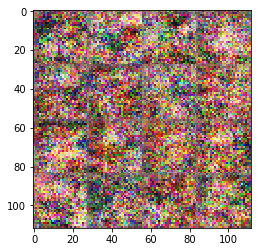

discriminator loss:  1.00656 generator loss:  0.693035
discriminator loss:  1.00652 generator loss:  0.693084


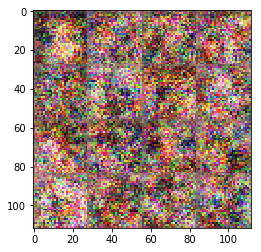

discriminator loss:  1.00651 generator loss:  0.693072
discriminator loss:  1.00647 generator loss:  0.69309


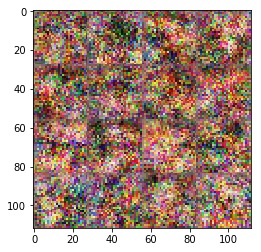

discriminator loss:  1.00672 generator loss:  0.692859
discriminator loss:  1.0067 generator loss:  0.693035


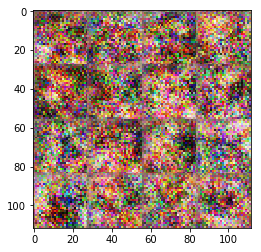

discriminator loss:  1.0066 generator loss:  0.693036
discriminator loss:  1.00653 generator loss:  0.693033


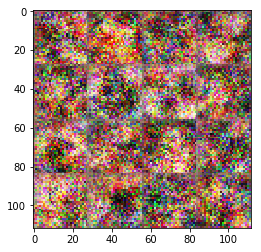

discriminator loss:  1.00648 generator loss:  0.693077
discriminator loss:  1.00649 generator loss:  0.693087


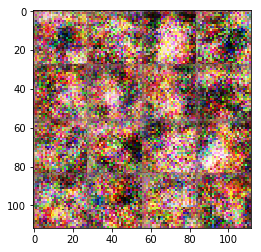

discriminator loss:  1.00689 generator loss:  0.692843
discriminator loss:  1.00946 generator loss:  0.691701


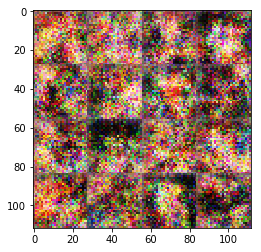

discriminator loss:  1.00756 generator loss:  0.692297
discriminator loss:  1.1664 generator loss:  0.652014


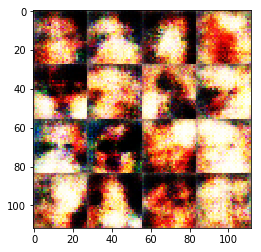

discriminator loss:  1.20665 generator loss:  0.609485
discriminator loss:  1.06487 generator loss:  0.681905


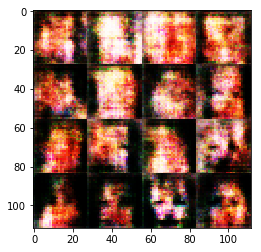

discriminator loss:  1.07142 generator loss:  0.685405
discriminator loss:  1.06052 generator loss:  0.679962


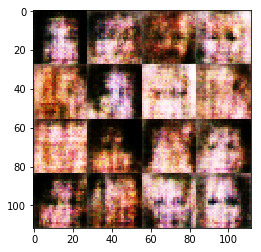

discriminator loss:  1.01015 generator loss:  0.690345
discriminator loss:  1.09425 generator loss:  0.656716


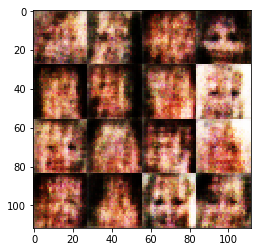

discriminator loss:  1.04048 generator loss:  0.683379
discriminator loss:  1.01523 generator loss:  0.68838


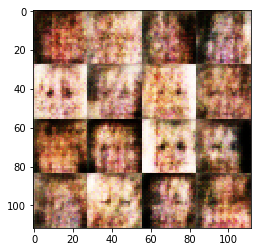

discriminator loss:  1.05566 generator loss:  0.690259
discriminator loss:  1.02286 generator loss:  0.68609


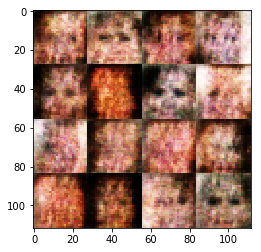

discriminator loss:  1.01435 generator loss:  0.690459
discriminator loss:  1.00882 generator loss:  0.691352


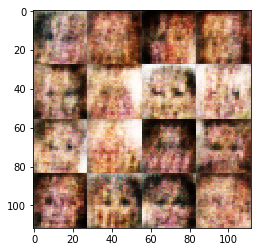

discriminator loss:  1.0284 generator loss:  0.688898
discriminator loss:  1.00879 generator loss:  0.687547


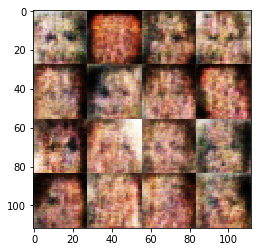

discriminator loss:  1.05089 generator loss:  0.678881
discriminator loss:  1.09856 generator loss:  0.679453


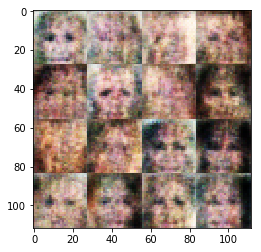

discriminator loss:  1.0615 generator loss:  0.679815
discriminator loss:  1.0982 generator loss:  0.682918


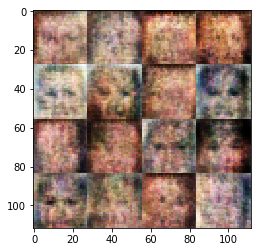

discriminator loss:  1.00977 generator loss:  0.692935
discriminator loss:  1.03619 generator loss:  0.682163


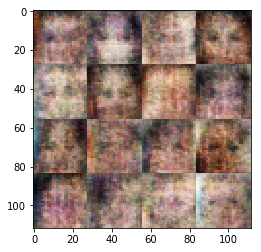

discriminator loss:  1.04794 generator loss:  0.671082
discriminator loss:  1.02816 generator loss:  0.685701


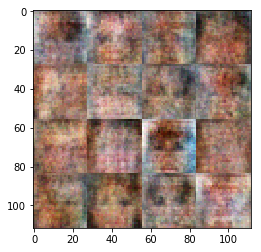

discriminator loss:  1.39063 generator loss:  0.692836
discriminator loss:  1.38631 generator loss:  0.693134


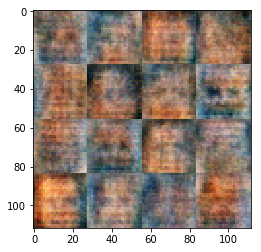

discriminator loss:  1.38649 generator loss:  0.692955
discriminator loss:  1.38632 generator loss:  0.693123


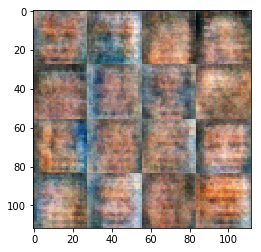

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.3863 generator loss:  0.693138


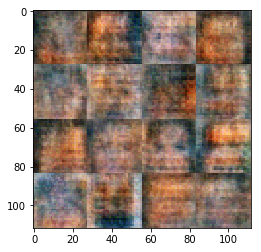

discriminator loss:  1.3864 generator loss:  0.693048
discriminator loss:  1.38631 generator loss:  0.693134


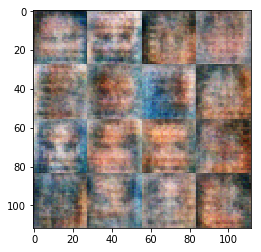

discriminator loss:  1.3863 generator loss:  0.693138
discriminator loss:  1.3863 generator loss:  0.693145


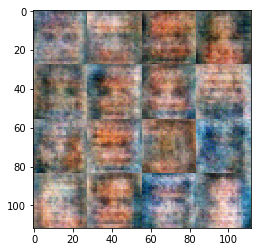

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.3863 generator loss:  0.693143


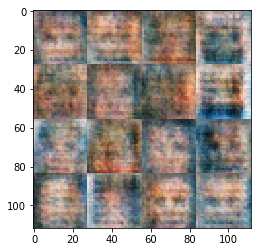

discriminator loss:  1.3863 generator loss:  0.693146
discriminator loss:  1.3863 generator loss:  0.693145


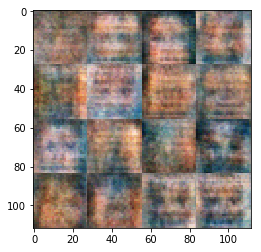

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.38629 generator loss:  0.693147


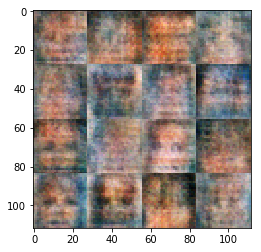

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.38629 generator loss:  0.693147


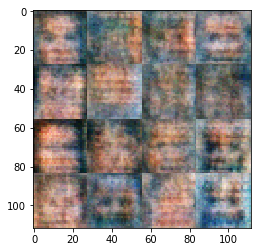

discriminator loss:  1.3863 generator loss:  0.693146
discriminator loss:  1.38629 generator loss:  0.693147


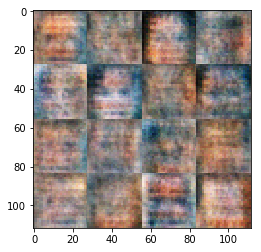

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.38631 generator loss:  0.693134


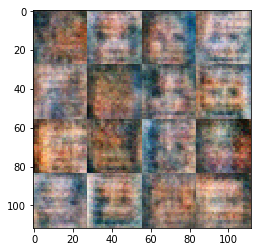

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.38629 generator loss:  0.693147


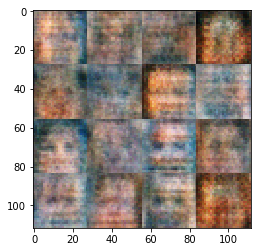

discriminator loss:  1.3863 generator loss:  0.693146
discriminator loss:  1.38629 generator loss:  0.693147


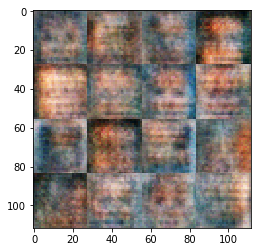

discriminator loss:  1.3863 generator loss:  0.693145
discriminator loss:  1.38629 generator loss:  0.693147


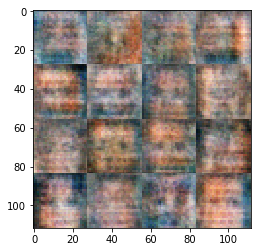

discriminator loss:  1.38629 generator loss:  0.693147
discriminator loss:  1.3863 generator loss:  0.693143


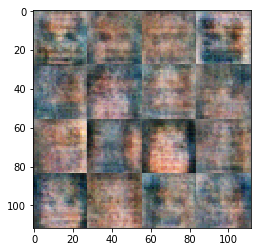

discriminator loss:  1.38629 generator loss:  0.693147


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.